In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchsummary import summary

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import pathlib
import numpy as np
import random
import os

import cv2
import glob
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [16]:
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
      
        resnet50 = models.resnet50(pretrained=True)

        # self.resnet50 = models.resnet50(pretrained=True)
        modules = list(resnet50.children())[:-1]
        self.resnet50 = nn.Sequential(*modules)

        # in_features = self.resnet50.fc.in_features
        # out_features = self.resnet50.fc.out_features
        
        self.fc = nn.Linear(resnet50 .fc.in_features, num_classes)
        
        

    def forward(self, x):
        # Pass the input through the ResNet model
        x = self.resnet50(x)
        
        # Flatten the output tensor
        x = x.view(x.size(0), -1)
        
        # Pass the output through the fully connected layer
        x = self.fc(x)
        return x

In [17]:
for dirpath, dirnames, filenames in os.walk("Dataset"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

bean_class = len(os.listdir("data/train"))

dataset_dir = pathlib.Path("data/train")
class_names = np.array(sorted([item.name for item in dataset_dir.glob("*")]))
print(class_names)

['class_0' 'class_1' 'class_2' 'class_3' 'class_4' 'class_5' 'class_6'
 'class_7' 'class_8' 'class_9' 'class_A' 'class_B' 'class_C' 'class_D'
 'class_E' 'class_F' 'class_G' 'class_H' 'class_I' 'class_J' 'class_K'
 'class_L' 'class_M' 'class_N' 'class_O' 'class_P' 'class_Q' 'class_R'
 'class_S' 'class_T' 'class_U' 'class_V' 'class_W' 'class_X' 'class_Y'
 'class_Z']


In [18]:
# Define the hyperparameters and optimizer
num_epochs = 8
learning_rate = 0.001
batch_size = 8
num_classes = 36

# Own Model
model = ResNet50(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 2: Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

d:\Salma\Coba\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Salma\Coba\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229,0.224,0.225)),
    ]
)

# Define the dataset
train_set = datasets.ImageFolder(root='data/train/', transform=transform)

# Define a data loader to iterate over the dataset
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Define the dataset
val_set = datasets.ImageFolder(root='data/val/', transform=transform)

# Define a data loader to iterate over the dataset
test_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)


In [21]:
# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print('[Epoch %d, Batch %5d] loss: %.3f' %
                  (epoch+1, i+1, running_loss / 100))
            running_loss = 0.0
    
    correct = 0
    total = 0

    # Calculate training accuracy
    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_acc = correct / total
    print('Training Accuracy: {:.2f}%'.format(train_acc * 100)) 

d:\Salma\Coba\venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[Epoch 1, Batch   100] loss: 3.170
Training Accuracy: 50.93%
[Epoch 2, Batch   100] loss: 1.018
Training Accuracy: 81.25%
[Epoch 3, Batch   100] loss: 0.773
Training Accuracy: 81.37%
[Epoch 4, Batch   100] loss: 0.344
Training Accuracy: 95.25%
[Epoch 5, Batch   100] loss: 0.160
Training Accuracy: 94.91%
[Epoch 6, Batch   100] loss: 0.146
Training Accuracy: 97.22%
[Epoch 7, Batch   100] loss: 0.099
Training Accuracy: 98.84%
[Epoch 8, Batch   100] loss: 0.101
Training Accuracy: 96.18%


In [22]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    predictions = []
    ground_truths = []
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        predictions.extend(predicted.numpy())
        ground_truths.extend(labels.numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print('Validating Accuracy: {:.2f}%'.format(test_acc * 100))

Validating Accuracy: 95.83%


<Axes: >

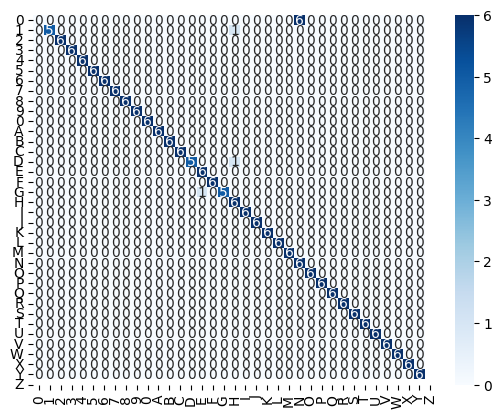

In [27]:
cm = confusion_matrix(ground_truths, predictions)
labels_category = ['0','1','2','3','4','5','6','7','8','9','0','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels= labels_category, yticklabels=labels_category)

In [36]:
summary(model, (3, 224, 224), 8)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 112, 112]           9,408
       BatchNorm2d-2          [8, 64, 112, 112]             128
              ReLU-3          [8, 64, 112, 112]               0
         MaxPool2d-4            [8, 64, 56, 56]               0
            Conv2d-5            [8, 64, 56, 56]           4,096
       BatchNorm2d-6            [8, 64, 56, 56]             128
              ReLU-7            [8, 64, 56, 56]               0
            Conv2d-8            [8, 64, 56, 56]          36,864
       BatchNorm2d-9            [8, 64, 56, 56]             128
             ReLU-10            [8, 64, 56, 56]               0
           Conv2d-11           [8, 256, 56, 56]          16,384
      BatchNorm2d-12           [8, 256, 56, 56]             512
           Conv2d-13           [8, 256, 56, 56]          16,384
      BatchNorm2d-14           [8, 256,